# Scraping data of disney movies

In [98]:
import requests
from bs4 import BeautifulSoup

In [318]:
def create_soup(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "lxml")
        return soup
    else:
        print("No Response")

## Scraping data of a movie

In [115]:
url = "https://en.wikipedia.org/wiki/Prince_of_Persia:_The_Sands_of_Time_(film)"
soup = create_soup(url)

In [116]:
def get_content_value(row_data):
    # Removing the sup (superscript) tag
    for sup in row_data.select("sup"):
        sup.extract() 
    # Extracting the relevant cleaned text
    # Strip the trailing spaces, and join bits of text by space in-between. Also replace escape characters.
    if row_data.select("li"):
        value = [li.get_text(" ", strip=True).replace("\xa0", " ") for li in row_data.select("li")]
    else:
        value = row_data.get_text(" ", strip=True).replace("\xa0", " ")
    return value

table = soup.select("table.infobox.vevent")[0]
table_rows = table.select("tr")
movie_info = {}
for index, row in enumerate(table_rows):
    if index == 0:
        title = row.th.get_text()
        movie_info["title"] = title
    elif index == 1:
        # Skip the picture
        continue
    else:
        label = row.th.get_text(" ", strip=True)
        value = get_content_value(row.td)
        movie_info[label] = value
        
movie_info

{'title': 'Prince of Persia:The Sands of Time',
 'Directed by': 'Mike Newell',
 'Screenplay by': ['Boaz Yakin', 'Doug Miro', 'Carlo Bernard'],
 'Story by': 'Jordan Mechner',
 'Based on': 'Prince of Persia by Jordan Mechner',
 'Produced by': 'Jerry Bruckheimer',
 'Starring': ['Jake Gyllenhaal',
  'Ben Kingsley',
  'Gemma Arterton',
  'Alfred Molina'],
 'Cinematography': 'John Seale',
 'Edited by': ['Michael Kahn', 'Martin Walsh', 'Mick Audsley'],
 'Music by': 'Harry Gregson-Williams',
 'Production companies': ['Walt Disney Pictures', 'Jerry Bruckheimer Films'],
 'Distributed by': 'Walt Disney Studios Motion Pictures',
 'Release dates': ['May 9, 2010 ( 2010-05-09 ) (London premiere)',
  'May 28, 2010 ( 2010-05-28 ) (United States)'],
 'Running time': '116 minutes',
 'Country': 'United States',
 'Language': 'English',
 'Budget': '$150–200 million',
 'Box office': '$336.4 million'}

## Scraping url of all movies

In [131]:
url = "https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films"
soup = create_soup(url)

In [132]:
movies_url = {}
# Excluding last 2 tables of 'Undated films' and 'In development'
tables = soup.select("table.wikitable")[:-2]
# Selecting only the <i> tags which have <anchor> tag available
for table in tables:
    movie_anchors = table.select("tbody tr td i a")
    for movie_anchor in movie_anchors:
        title = movie_anchor.get_text(strip=True)
        href = movie_anchor["href"]
        absolute_url = "https://en.wikipedia.org" + href
        movies_url[title] = absolute_url

movies_url

{'Snow White and the Seven Dwarfs': 'https://en.wikipedia.org/wiki/Snow_White_and_the_Seven_Dwarfs_(1937_film)',
 'Pinocchio': 'https://en.wikipedia.org/wiki/Pinocchio_(2022_live-action_film)',
 'Fantasia': 'https://en.wikipedia.org/wiki/Fantasia_(1940_film)',
 'The Reluctant Dragon': 'https://en.wikipedia.org/wiki/The_Reluctant_Dragon_(1941_film)',
 'Dumbo': 'https://en.wikipedia.org/wiki/Dumbo_(2019_film)',
 'Bambi': 'https://en.wikipedia.org/wiki/Bambi',
 'Saludos Amigos': 'https://en.wikipedia.org/wiki/Saludos_Amigos',
 'Victory Through Air Power': 'https://en.wikipedia.org/wiki/Victory_Through_Air_Power_(film)',
 'The Three Caballeros': 'https://en.wikipedia.org/wiki/The_Three_Caballeros',
 'Make Mine Music': 'https://en.wikipedia.org/wiki/Make_Mine_Music',
 'Song of the South': 'https://en.wikipedia.org/wiki/Song_of_the_South',
 'Fun and Fancy Free': 'https://en.wikipedia.org/wiki/Fun_and_Fancy_Free',
 'Melody Time': 'https://en.wikipedia.org/wiki/Melody_Time',
 'So Dear to My He

## Combining both scrapings

In [378]:
def create_soup(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "lxml")
        return soup
    except Exception:
        print("No Response from url")
        return None

        
def get_movies_url(url):
    movies_url = {}
    soup = create_soup(url)
    if soup:
        # Excluding last 2 tables of 'Undated films' and 'In development'
        tables = soup.select("table.wikitable")[:-2]
        # Selecting only the <i> tags which have <anchor> tag available
        for table in tables:
            movie_anchors = table.select("tbody tr td:first-child i a")
            for movie_anchor in movie_anchors:
                try:
                    title = movie_anchor.get_text(strip=True)
                    href = movie_anchor["href"]
                    absolute_url = "https://en.wikipedia.org" + href
                    movies_url[title] = absolute_url
                except Exception as e:
                    print(f"Error parsing the movie_anchor:\n{movie_anchor}\n{e}")

    return movies_url


def get_movie_info(movie_url):
    movie_info = {}
    soup = create_soup(movie_url)
    if soup:
        table = soup.select("table.infobox.vevent")[0]
        table_rows = table.select("tr")

        for index, row in enumerate(table_rows):
            try:
                # Get title from first row of infobox table
                if index == 0:
                    title = row.th.get_text()
                    movie_info["title"] = title
                elif index == 1:
                    # Skip the picture
                    continue
                else:
                    # Some rows have only <th> while some have only <td> for example in 'Zoro' movie
                    # Skip these rows
                    if row.th and row.td:
                        label = row.th.get_text(" ", strip=True)
                        value = get_content_value(row.td)
                        movie_info[label] = value
                    else:
                        continue
            # Catch the exception in parsing row with comments showing the source of exception          
            except Exception as e:
                print(f"Could not parse value from row for movie: {title}")
                print(f"Error in row of infobox table: {index + 1}")
                print(e)
                return None
            
    return movie_info


def get_content_value(row_data):
    # Removing the <sup> (superscript) tag, <span> tag (which has hidden date) and <b> tag (used as heading in starring) 
    for tag in row_data.select("sup, span, b"):
        tag.decompose() 
        
    # Extracting the relevant cleaned text
    # If there are <li> or <br> tags then it (mostly) indicates list of texts otherwise it is single text
    # Strip the trailing spaces, and join bits of text by space in-between. Also replace escape characters.
    
    if row_data.select("li"):
        value = [li.get_text(" ", strip=True).replace("\xa0", " ") for li in row_data.select("li")]
    elif row_data.select("br"):
        value = [text for text in row_data.stripped_strings]
    else:
        value = row_data.get_text(" ", strip=True).replace("\xa0", " ")
    return value

In [379]:
movies_data = {}
movies_url = get_movies_url("https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films")
if movies_url:
    for index, (movie, url) in enumerate(movies_url.items()):
        if index%10 == 0:
            print(f"Scraping {index+1}th movie")
        movie_info = get_movie_info(url)
        if movie_info:
            movies_data[movie] = movie_info
        else:
            continue

Scraping 1th movie
Scraping 11th movie
Scraping 21th movie
Scraping 31th movie
Scraping 41th movie
Scraping 51th movie
Scraping 61th movie
Scraping 71th movie
Scraping 81th movie
Scraping 91th movie
Scraping 101th movie
Scraping 111th movie
Scraping 121th movie
Scraping 131th movie
Scraping 141th movie
Scraping 151th movie
Scraping 161th movie
Scraping 171th movie
Scraping 181th movie
Scraping 191th movie
Scraping 201th movie
Scraping 211th movie
Scraping 221th movie
Scraping 231th movie
Scraping 241th movie
Scraping 251th movie
Scraping 261th movie
Scraping 271th movie
Scraping 281th movie
Scraping 291th movie
Scraping 301th movie
Scraping 311th movie
Scraping 321th movie
Scraping 331th movie
Scraping 341th movie
Scraping 351th movie
Scraping 361th movie
Scraping 371th movie
Scraping 381th movie
Scraping 391th movie
Scraping 401th movie
Scraping 411th movie
Scraping 421th movie
Scraping 431th movie
Scraping 441th movie
Scraping 451th movie
Scraping 461th movie
Scraping 471th movie
Scr

In [380]:
len(movies_data) 
# We have scraped all the movies data successfully without any exception! 

514

In [381]:
for movie, data in list(movies_data.items())[:3]:
    print(movie)
    print(data)
    print("-----------")

Snow White and the Seven Dwarfs
{'title': 'Snow White and the Seven Dwarfs', 'Directed by': ['David Hand', 'Perce Pearce', 'William Cottrell', 'Larry Morey', 'Wilfred Jackson', 'Ben Sharpsteen'], 'Story by': ['Ted Sears', 'Richard Creedon', 'Otto Englander', 'Dick Rickard', 'Earl Hurd', 'Merrill De Maris', 'Dorothy Ann Blank', 'Webb Smith'], 'Based on': ['Snow White', 'by the', 'Brothers Grimm'], 'Produced by': 'Walt Disney', 'Starring': ['Adriana Caselotti', 'Roy Atwell', 'Pinto Colvig', 'Otis Harlan', 'Scotty Mattraw', 'Billy Gilbert', 'Eddie Collins'], 'Music by': ['Frank Churchill', 'Leigh Harline', 'Paul Smith'], 'Production company': 'Walt Disney Productions', 'Distributed by': 'RKO Radio Pictures', 'Release dates': ['December 21, 1937 ( Carthay Circle Theatre )', 'February 4, 1938 (United States)'], 'Running time': '83 minutes', 'Country': 'United States', 'Language': 'English', 'Budget': '$1.5 million', 'Box office': '$418 million'}
-----------
Pinocchio
{'title': 'Pinocchio', 

## Saving and loading data (JSON)


In [382]:
import json
with open("disney_data.json", "w", encoding="utf-8") as f:
    json.dump(movies_data, f, ensure_ascii=False, indent=2)

In [91]:
import json
with open("disney_data.json", "r", encoding="utf-8") as f:
    movies_data = json.load(f)

In [92]:
len(movies_data)

514

## Cleaning the data

### Coverting 'Running time' to integer

In [93]:
import re
def minute_to_integer(running_time):
    if not running_time:
        return None
    elif isinstance(running_time, list):
        running_time = running_time[0]
    return int(re.findall(r"\d+", running_time)[0])

In [94]:
for movie in movies_data.values():
    running_time = movie.get("Running time")
    movie["Running time (minutes)"] = minute_to_integer(running_time)

In [95]:
print([movie["Running time (minutes)"] for movie in movies_data.values()])

[83, 105, 126, 74, 112, 70, 42, 65, 71, 75, 94, 73, 75, 82, 68, 106, 96, 108, 84, 77, 92, 69, 81, 60, 127, 93, 104, 75, 73, 85, 81, 70, 90, 80, 75, 84, 83, 72, 97, 75, 99, 93, 22, 105, 95, 97, 134, 22, 69, 92, 126, 79, 97, 128, 73, 91, 105, 98, 130, 89, 93, 67, 98, 100, 118, 103, 110, 80, 79, 91, 91, 97, 118, 139, 131, 92, 87, 116, 93, 114, 110, 131, 101, 110, 84, 106, 75, 164, 106, 110, 99, 113, 108, 102, 85, 91, 93, 100, 100, 79, 96, 113, 89, 118, 92, 88, 92, 87, 93, 93, 93, 90, 83, 96, 88, 89, 91, 93, 92, 97, 100, 100, 89, 91, 112, 115, 95, 91, 96, 104, 74, 48, 77, 104, 103, 101, 94, 104, 90, 100, 88, 93, 98, 112, 84, 97, 97, 114, 96, 97, 109, 83, 90, 107, 96, 103, 91, 95, 105, 113, 80, 101, 90, 74, 90, 89, 110, 74, 93, 84, 135, 69, 77, 107, 93, 88, 108, 129, 121, 89, 104, 128, 86, 84, 108, 107, 96, 98, 105, 109, 94, 106, 102, 69, 118, 102, 102, 97, 111, 92, 100, 96, 96, 78, 81, 108, 89, 99, 89, 81, 92, 100, 89, 79, 91, 81, 101, 104, 103, 86, 106, 74, 22, 93, 92, 98, 76, 95, 72, 93,

### Converting Budget and Box office to floats

In [96]:
for movie in movies_data.values():
    print(movie.get("Budget")) 

$1.5 million
$150 million
$2.28 million
$600,000
$170 million
$858,000
None
$788,000
None
$1.35 million
$2.125 million
None
$1.5 million
$1.5 million
None
$84.21–95 million
$1.8 million
$150 –$200 million
None
$4 million
$2 million
$300,000
$1.8 million
None
$5 million
None
$60 million
None
None
None
None
None
None
$700,000
None
None
None
None
None
$6 million
$50 million
None
None
$2 million
None
None
$2.5 million
None
None
None
$4 million
$3.6 million
None
$15 million
None
None
$3 million
None
$3 million
None
None
None
None
None
None
None
None
None
$3 million
None
None
None
None
$4.4–6 million
None
None
None
None
None
None
None
None
None
None
None
$175–177 million
None
$5 million
None
None
None
None
$5 million
None
None
None
None
None
None
$4 million
None
None
None
$6.3 million
None
None
None
None
None
None
None
None
$5 million
None
None
None
None
$8 million
None
None
None
None
None
AU$1 million
None
None
None
None
$26 million
None
None
None
$7.5 million
None
$65 million
None
None
$3.

In [97]:
def money_conversion(money):
    if not money:
        return None
    if isinstance(money, list):
        money = "".join(money)

    pattern = r"""
        (\$|₽)                          # Currency symbol: dollar sign or ₽ (ruble).
        \s?                             # Optional whitespace.
        (\d+(?:\.\d+)?)                 # Digits (integer or decimal part).
        \s?                             # Optional whitespace.
        (?:
            (?:
                (?:–|-|—)               # Dash symbol: – or - or —.
                \$?                     # Optional dollar sign.
                (?:\d+(?:\.\d+)?)       # Digits (integer or decimal part).
            )
            |
            (?:to[^A-Za-z]+)            # "to" followed by non-alphabet characters.
        )?
        \s*                             # Optional whitespace.
        (million|billion)?              # million or billion.
    """

    match = re.search(pattern, money.replace(",", ""), re.VERBOSE | re.IGNORECASE)
    if not match:
        return None
    currency_symbol = match.group(1)
    value = match.group(2)
    ammount = match.group(3)

    # Formating cuurency symbol (in dollars)
    if currency_symbol == "$":
        symbol = 1
    elif currency_symbol == "₽":
        symbol = 0.010661202

    # Formatting value
    value = float(value)

    # Formatting ammount (in dollars)
    if not ammount:
        ammount = 1
    elif ammount.lower() == "million":
        ammount = 1000000
    elif ammount.lower() == "billion":
        ammount = 1000000000
    
    formatted_money = symbol * value * ammount
    return formatted_money

**Check out test_money_conversion.py for unit testing. Checking for any remaining errors:**

In [98]:
for movie in movies_data.values():
    budget = movie.get("Budget")
    try:
        budget = money_conversion(budget)
        print(budget)
        if budget:
            if budget < 1000: # Abnormal
                raise Exception
    except:
        print("--------")
        print(movie.get("Budget"))

1500000.0
150000000.0
2280000.0
600000.0
170000000.0
858000.0
None
788000.0
None
1350000.0
2125000.0
None
1500000.0
1500000.0
None
84210000.0
1800000.0
150000000.0
None
4000000.0
2000000.0
300000.0
1800000.0
None
5000000.0
None
60000000.0
None
None
None
None
None
None
700000.0
None
None
None
None
None
6000000.0
50000000.0
None
None
2000000.0
None
None
2500000.0
None
None
None
4000000.0
3600000.0
None
15000000.0
None
None
3000000.0
None
3000000.0
None
None
None
None
None
None
None
None
None
3000000.0
None
None
None
None
4400000.0
None
None
None
None
None
None
None
None
None
None
None
175000000.0
None
5000000.0
None
None
None
None
5000000.0
None
None
None
None
None
None
4000000.0
None
None
None
6300000.0
None
None
None
None
None
None
None
None
5000000.0
None
None
None
None
8000000.0
None
None
None
None
None
1000000.0
None
None
None
None
26000000.0
None
None
None
7500000.0
None
65000000.0
None
None
3500000.0
None
None
None
5250000.0
20000000.0
4500000.0
9000000.0
None
6000000.0
20000000.0

In [99]:
for movie in movies_data.values():
    box_office = movie.get("Box office")
    try:
        box_office = money_conversion(box_office)
        print(box_office)
        if box_office:
            if box_office < 1000:
                raise Exception
    except:
        print("--------")
        print(movie.get("Box office"))

418000000.0
None
76400000.0
960000.0
353300000.0
267399999.99999997
1000000.0
799000.0
3355000.0
3275000.0
65000000.0
3165000.0
2560000.0
3700000.0
1625000.0
542400000.0
4099999.9999999995
1024999999.9999999
2100000.0
87400000.0
1000000.0
2600000.0
None
1750000.0
28200000.0
2150000.0
None
2100000.0
1600000.0
1700000.0
None
None
2750000.0
None
1750000.0
6250000.0
2000000.0
1800000.0
2500000.0
51600000.0
87100000.0
2600000.0
None
1700000.0
3100000.0
None
3750000.0
None
2300000.0
None
40000000.0
303000000.0
25300000.0
92100000.0
2100000.0
1400000.0
4600000.0
3500000.0
5000000.0
None
None
None
21745500.0
22100000.0
2550000.0
3000000.0
4350000.0
4200000.0
22200000.0
1600000.0
4000000.0
2250000.0
3500000.0
103100000.0
3500000.0
1275000.0
4000000.0
28068222.0
6200000.0
22565634.0
None
16207116.0
3000000.0
1900000.0
4000000.0
966600000.0
None
5000000.0
21540050.0
2250000.0
4150000.0
3300000.0
51200000.0
1300000.0
None
5500000.0
None
18607492.0
4000000.0
191000000.0
None
None
5100000.0
17900000

**Adding 'Box office (float)' and 'Budget (float)' fields**

In [100]:
for movie in movies_data.values():
    Box_office = movie.get("Box office")
    Budget = movie.get("Budget")
    movie["Box office ($)"] = money_conversion(Box_office)
    movie["Budget ($)"] = money_conversion(Budget)

In [101]:
list(movies_data.items())[:5]

[('Snow White and the Seven Dwarfs',
  {'title': 'Snow White and the Seven Dwarfs',
   'Directed by': ['David Hand',
    'Perce Pearce',
    'William Cottrell',
    'Larry Morey',
    'Wilfred Jackson',
    'Ben Sharpsteen'],
   'Story by': ['Ted Sears',
    'Richard Creedon',
    'Otto Englander',
    'Dick Rickard',
    'Earl Hurd',
    'Merrill De Maris',
    'Dorothy Ann Blank',
    'Webb Smith'],
   'Based on': ['Snow White', 'by the', 'Brothers Grimm'],
   'Produced by': 'Walt Disney',
   'Starring': ['Adriana Caselotti',
    'Roy Atwell',
    'Pinto Colvig',
    'Otis Harlan',
    'Scotty Mattraw',
    'Billy Gilbert',
    'Eddie Collins'],
   'Music by': ['Frank Churchill', 'Leigh Harline', 'Paul Smith'],
   'Production company': 'Walt Disney Productions',
   'Distributed by': 'RKO Radio Pictures',
   'Release dates': ['December 21, 1937 ( Carthay Circle Theatre )',
    'February 4, 1938 (United States)'],
   'Running time': '83 minutes',
   'Country': 'United States',
   'Lang

### Converting time to datetime object

In [102]:
for movie in movies_data.values():
    movie = movie.get('Release dates')
    if movie:
        print(movie[0])

December 21, 1937 ( Carthay Circle Theatre )
March 11, 2019 ( Los Angeles )
August 9, 1942 ( London )
August 24, 1942 (Rio de Janeiro)
December 21, 1944 (Mexico City)
April 20, 1946 (New York City)
November 12, 1946 (premiere)
November 29, 1948 (Chicago)
February 13, 2015 ( Berlinale )
June 22, 1950 (London)
February 25, 2010 ( Odeon Leicester Square )
13 March 1952 (London)
26 October 1953 (London)
June 24, 1959 (Dublin)
June 1960 ( Berlin )
July 20, 1998 (Los Angeles)
November 14, 1962 (London, premiere)
December 12, 1963 (London)
11 December 1963 ( New York City )
August 27, 1964 ( Los Angeles )
February 4, 1966 (premiere)
June 29, 1966 (Premiere)
April 4, 2016 ( El Capitan Theatre )
June 23, 1967
December 24, 1968 (limited)
December 11, 1970 (premiere)
October 7, 1971 (United Kingdom)
August 4, 2003 ( Los Angeles )
May 26, 1976
August 8, 2016 ( El Capitan Theatre )
July 19, 1979 (London)
December 18, 1979 (United Kingdom)
April 17, 1980 (New York City)
December 6, 1980 ( Los Angele

In [103]:
import re
from datetime import datetime
def convert_date(date):
    if not date:
        return None
    if isinstance(date, list):
        date = date[0]
    pattern = r"([A-Za-z]+)\s(\d{1,2},)\s(\d{4})" # matches 'November 14, 1962'
    match = re.search(pattern, date)
    date_format = "%B %d, %Y"
    if not match:
        pattern = r"(\d{1,2})\s([A-Za-z]+)\s(\d{4})" # matches '11 December 1963'
        match = re.search(pattern, date)
        date_format = "%d %B %Y"
        if not match:
            pattern = r"([A-Za-z]+)\s(\d{4})" # matches 'December 1963'
            match = re.search(pattern, date)
            date_format = "%B %Y"
            if not match:
                pattern = r"(\d{4})" # matches '2009'
                match = re.search(pattern, date)
                date_format = "%Y"
                
    return datetime.strptime(match.group(), date_format)

**Checking for any remaining errors**

In [104]:
for movie in movies_data.values():
    # Some movies have 'Release dates' field while some have 'Release date' while others don't have a one
    date = movie.get('Release dates')
    if not date:
        date = movie.get("Release date")
    try:
        print(convert_date(date))
    except:
        print("-----------------------------")
        print(date)

1937-12-21 00:00:00
2022-09-08 00:00:00
1940-11-13 00:00:00
1941-06-27 00:00:00
2019-03-11 00:00:00
1942-08-09 00:00:00
1942-08-24 00:00:00
1943-07-17 00:00:00
1944-12-21 00:00:00
1946-04-20 00:00:00
1946-11-12 00:00:00
1947-09-27 00:00:00
1948-05-27 00:00:00
1948-11-29 00:00:00
1949-10-05 00:00:00
2015-02-13 00:00:00
1950-06-22 00:00:00
2010-02-25 00:00:00
1952-03-13 00:00:00
1953-02-05 00:00:00
1953-07-23 00:00:00
1953-11-10 00:00:00
1953-10-26 00:00:00
1954-08-17 00:00:00
1954-12-23 00:00:00
1955-05-25 00:00:00
2019-11-12 00:00:00
1955-09-14 00:00:00
1955-12-22 00:00:00
1956-06-08 00:00:00
1956-07-18 00:00:00
1956-09-04 00:00:00
1956-12-20 00:00:00
1957-06-19 00:00:00
1957-08-28 00:00:00
1957-12-25 00:00:00
1958-07-08 00:00:00
1958-08-12 00:00:00
1958-12-25 00:00:00
1959-01-29 00:00:00
2006-03-10 00:00:00
1959-06-24 00:00:00
None
1959-11-10 00:00:00
1960-01-21 00:00:00
1960-02-24 00:00:00
1960-05-19 00:00:00
None
1960-06-01 00:00:00
1960-11-01 00:00:00
1960-12-21 00:00:00
1961-01-25

**Adding the 'Realease date (datetime)' field**

In [105]:
for movie in movies_data.values():
    date = movie.get('Release dates')
    if not date:
        date = movie.get("Release date")
        
    movie["Release date (datetime)"] = convert_date(date)

In [106]:
list(movies_data.items())[:10]

[('Snow White and the Seven Dwarfs',
  {'title': 'Snow White and the Seven Dwarfs',
   'Directed by': ['David Hand',
    'Perce Pearce',
    'William Cottrell',
    'Larry Morey',
    'Wilfred Jackson',
    'Ben Sharpsteen'],
   'Story by': ['Ted Sears',
    'Richard Creedon',
    'Otto Englander',
    'Dick Rickard',
    'Earl Hurd',
    'Merrill De Maris',
    'Dorothy Ann Blank',
    'Webb Smith'],
   'Based on': ['Snow White', 'by the', 'Brothers Grimm'],
   'Produced by': 'Walt Disney',
   'Starring': ['Adriana Caselotti',
    'Roy Atwell',
    'Pinto Colvig',
    'Otis Harlan',
    'Scotty Mattraw',
    'Billy Gilbert',
    'Eddie Collins'],
   'Music by': ['Frank Churchill', 'Leigh Harline', 'Paul Smith'],
   'Production company': 'Walt Disney Productions',
   'Distributed by': 'RKO Radio Pictures',
   'Release dates': ['December 21, 1937 ( Carthay Circle Theatre )',
    'February 4, 1938 (United States)'],
   'Running time': '83 minutes',
   'Country': 'United States',
   'Lang

### Creating dataframe and further cleaning it

In [107]:
import pandas as pd
import numpy as np

In [108]:
df = pd.DataFrame(movies_data)

In [109]:
df = df.T

In [110]:
df.head()

,title,Directed by,Story by,Based on,Produced by,Starring,Music by,Production company,Distributed by,Release dates,...,Producers,Editor,Kanji,Transcriptions,Revised Hepburn,Adaptation by,Traditional Chinese,Simplified Chinese,Original title,Layouts by
Snow White and the Seven Dwarfs,Snow White and the Seven Dwarfs,"[David Hand, Perce Pearce, William Cottrell, L...","[Ted Sears, Richard Creedon, Otto Englander, D...","[Snow White, by the, Brothers Grimm]",Walt Disney,"[Adriana Caselotti, Roy Atwell, Pinto Colvig, ...","[Frank Churchill, Leigh Harline, Paul Smith]",Walt Disney Productions,RKO Radio Pictures,"[December 21, 1937 ( Carthay Circle Theatre ),...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pinocchio,Pinocchio,Robert Zemeckis,NaN,"[Disney, 's, Pinocchio, The Adventures of Pino...","[Andrew Milano, Chris Weitz, Robert Zemeckis, ...","[Tom Hanks, Benjamin Evan Ainsworth, Joseph Go...",Alan Silvestri,NaN,Disney+,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fantasia,Fantasia,"[Samuel Armstrong, James Algar, Bill Roberts, ...","[Joe Grant, Dick Huemer]",NaN,"[Walt Disney, Ben Sharpsteen]","[Leopold Stokowski, Deems Taylor]",See program,Walt Disney Productions,RKO Radio Pictures,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
The Reluctant Dragon,The Reluctant Dragon,"[Alfred Werker, (live action), Hamilton Luske,...",NaN,NaN,Walt Disney,"[Robert Benchley, Frances Gifford, Buddy Peppe...","[Frank Churchill, Larry Morey]",Walt Disney Productions,RKO Radio Pictures,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dumbo,Dumbo,Tim Burton,NaN,[Disney 's Dumbo by Otto Englander Joe Grant D...,"[Justin Springer, Ehren Kruger, Katterli Fraue...","[Colin Farrell, Michael Keaton, Danny DeVito, ...",Danny Elfman,NaN,"[Walt Disney Studios, Motion Pictures]","[March 11, 2019 ( Los Angeles ), March 29, 201...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Converting None to NaN for consistency**

In [111]:
df = df.fillna(np.nan)

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514 entries, Snow White and the Seven Dwarfs to Mufasa: The Lion King
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    514 non-null    object        
 1   Directed by              510 non-null    object        
 2   Story by                 154 non-null    object        
 3   Based on                 272 non-null    object        
 4   Produced by              502 non-null    object        
 5   Starring                 479 non-null    object        
 6   Music by                 508 non-null    object        
 7   Production company       200 non-null    object        
 8   Distributed by           510 non-null    object        
 9   Release dates            190 non-null    object        
 10  Running time             508 non-null    object        
 11  Country                  440 non-null    object       

**Merging production company into production companies and Dropping unnecessary columns**

In [113]:
df['Production companies'] = df['Production companies'].fillna(df["Production company"])

columns_to_drop = list(df.columns)[26:]
columns_to_drop.extend(["Narrated by", "Release date", "Release dates", "Running time", "Budget", "Box office", "Based on", "Production company", "Written by", "Story by"])
df.drop(columns = columns_to_drop, inplace=True)

In [114]:
df.head()

,title,Directed by,Produced by,Starring,Music by,Distributed by,Country,Language,Running time (minutes),Box office ($),Budget ($),Release date (datetime),Screenplay by,Cinematography,Edited by,Production companies
Snow White and the Seven Dwarfs,Snow White and the Seven Dwarfs,"[David Hand, Perce Pearce, William Cottrell, L...",Walt Disney,"[Adriana Caselotti, Roy Atwell, Pinto Colvig, ...","[Frank Churchill, Leigh Harline, Paul Smith]",RKO Radio Pictures,United States,English,83.0,418000000.0,1500000.0,1937-12-21,NaN,NaN,NaN,Walt Disney Productions
Pinocchio,Pinocchio,Robert Zemeckis,"[Andrew Milano, Chris Weitz, Robert Zemeckis, ...","[Tom Hanks, Benjamin Evan Ainsworth, Joseph Go...",Alan Silvestri,Disney+,United States,English,105.0,NaN,150000000.0,2022-09-08,"[Robert Zemeckis, Chris Weitz]",Don Burgess,"[Jesse Goldsmith, Mick Audsley]","[Walt Disney Pictures, Depth of Field, ImageMo..."
Fantasia,Fantasia,"[Samuel Armstrong, James Algar, Bill Roberts, ...","[Walt Disney, Ben Sharpsteen]","[Leopold Stokowski, Deems Taylor]",See program,RKO Radio Pictures,United States,English,126.0,76400000.0,2280000.0,1940-11-13,NaN,James Wong Howe,NaN,Walt Disney Productions
The Reluctant Dragon,The Reluctant Dragon,"[Alfred Werker, (live action), Hamilton Luske,...",Walt Disney,"[Robert Benchley, Frances Gifford, Buddy Peppe...","[Frank Churchill, Larry Morey]",RKO Radio Pictures,United States,English,74.0,960000.0,600000.0,1941-06-27,NaN,Bert Glennon,Paul Weatherwax,Walt Disney Productions
Dumbo,Dumbo,Tim Burton,"[Justin Springer, Ehren Kruger, Katterli Fraue...","[Colin Farrell, Michael Keaton, Danny DeVito, ...",Danny Elfman,"[Walt Disney Studios, Motion Pictures]",United States,English,112.0,353300000.0,170000000.0,2019-03-11,Ehren Kruger,Ben Davis,Chris Lebenzon,"[Walt Disney Pictures, Tim Burton Productions,..."


**Cleaning the list values**

In [115]:
def clean_list_value(list_value):
    if isinstance(list_value, list):
        cleaned_list_value = []
        for item in list_value:
            if item == "," or item =="" or (item.startswith("(") and item.endswith(")")):
                continue
            else:
                cleaned_list_value.append(item)
        return cleaned_list_value
    else:
        return list_value

In [116]:
cleaned_df = df.applymap(clean_list_value)
cleaned_df.head()

,title,Directed by,Produced by,Starring,Music by,Distributed by,Country,Language,Running time (minutes),Box office ($),Budget ($),Release date (datetime),Screenplay by,Cinematography,Edited by,Production companies
Snow White and the Seven Dwarfs,Snow White and the Seven Dwarfs,"[David Hand, Perce Pearce, William Cottrell, L...",Walt Disney,"[Adriana Caselotti, Roy Atwell, Pinto Colvig, ...","[Frank Churchill, Leigh Harline, Paul Smith]",RKO Radio Pictures,United States,English,83.0,418000000.0,1500000.0,1937-12-21,NaN,NaN,NaN,Walt Disney Productions
Pinocchio,Pinocchio,Robert Zemeckis,"[Andrew Milano, Chris Weitz, Robert Zemeckis, ...","[Tom Hanks, Benjamin Evan Ainsworth, Joseph Go...",Alan Silvestri,Disney+,United States,English,105.0,NaN,150000000.0,2022-09-08,"[Robert Zemeckis, Chris Weitz]",Don Burgess,"[Jesse Goldsmith, Mick Audsley]","[Walt Disney Pictures, Depth of Field, ImageMo..."
Fantasia,Fantasia,"[Samuel Armstrong, James Algar, Bill Roberts, ...","[Walt Disney, Ben Sharpsteen]","[Leopold Stokowski, Deems Taylor]",See program,RKO Radio Pictures,United States,English,126.0,76400000.0,2280000.0,1940-11-13,NaN,James Wong Howe,NaN,Walt Disney Productions
The Reluctant Dragon,The Reluctant Dragon,"[Alfred Werker, Hamilton Luske, Jack Cutting, ...",Walt Disney,"[Robert Benchley, Frances Gifford, Buddy Peppe...","[Frank Churchill, Larry Morey]",RKO Radio Pictures,United States,English,74.0,960000.0,600000.0,1941-06-27,NaN,Bert Glennon,Paul Weatherwax,Walt Disney Productions
Dumbo,Dumbo,Tim Burton,"[Justin Springer, Ehren Kruger, Katterli Fraue...","[Colin Farrell, Michael Keaton, Danny DeVito, ...",Danny Elfman,"[Walt Disney Studios, Motion Pictures]",United States,English,112.0,353300000.0,170000000.0,2019-03-11,Ehren Kruger,Ben Davis,Chris Lebenzon,"[Walt Disney Pictures, Tim Burton Productions,..."



## Keeping Consistency of type in columns

In [117]:
def convert_to_list(value):
    if isinstance(value, str):
        return [x.strip() for x in value.split(",")]
    else:
        return value
    
def convert_to_str(value):
    if isinstance(value, list):
        return ", ".join(value)
    return value

In [118]:
list_columns = list(cleaned_df.columns[1:6]) + list(cleaned_df.columns[12:])
list_columns 

['Directed by',
 'Produced by',
 'Starring',
 'Music by',
 'Distributed by',
 'Screenplay by',
 'Cinematography',
 'Edited by',
 'Production companies']

In [119]:
str_columns = ["Country", "Language"]

In [120]:
cleaned_df[list_columns] = cleaned_df[list_columns].applymap(convert_to_list)

In [121]:
cleaned_df[str_columns] = cleaned_df[str_columns].applymap(convert_to_str)

In [122]:
cleaned_df.at["Fantasia", "Music by"] = np.nan

In [123]:
cleaned_df.head()

,title,Directed by,Produced by,Starring,Music by,Distributed by,Country,Language,Running time (minutes),Box office ($),Budget ($),Release date (datetime),Screenplay by,Cinematography,Edited by,Production companies
Snow White and the Seven Dwarfs,Snow White and the Seven Dwarfs,"[David Hand, Perce Pearce, William Cottrell, L...",[Walt Disney],"[Adriana Caselotti, Roy Atwell, Pinto Colvig, ...","[Frank Churchill, Leigh Harline, Paul Smith]",[RKO Radio Pictures],United States,English,83.0,418000000.0,1500000.0,1937-12-21,NaN,NaN,NaN,[Walt Disney Productions]
Pinocchio,Pinocchio,[Robert Zemeckis],"[Andrew Milano, Chris Weitz, Robert Zemeckis, ...","[Tom Hanks, Benjamin Evan Ainsworth, Joseph Go...",[Alan Silvestri],[Disney+],United States,English,105.0,NaN,150000000.0,2022-09-08,"[Robert Zemeckis, Chris Weitz]",[Don Burgess],"[Jesse Goldsmith, Mick Audsley]","[Walt Disney Pictures, Depth of Field, ImageMo..."
Fantasia,Fantasia,"[Samuel Armstrong, James Algar, Bill Roberts, ...","[Walt Disney, Ben Sharpsteen]","[Leopold Stokowski, Deems Taylor]",NaN,[RKO Radio Pictures],United States,English,126.0,76400000.0,2280000.0,1940-11-13,NaN,[James Wong Howe],NaN,[Walt Disney Productions]
The Reluctant Dragon,The Reluctant Dragon,"[Alfred Werker, Hamilton Luske, Jack Cutting, ...",[Walt Disney],"[Robert Benchley, Frances Gifford, Buddy Peppe...","[Frank Churchill, Larry Morey]",[RKO Radio Pictures],United States,English,74.0,960000.0,600000.0,1941-06-27,NaN,[Bert Glennon],[Paul Weatherwax],[Walt Disney Productions]
Dumbo,Dumbo,[Tim Burton],"[Justin Springer, Ehren Kruger, Katterli Fraue...","[Colin Farrell, Michael Keaton, Danny DeVito, ...",[Danny Elfman],"[Walt Disney Studios, Motion Pictures]",United States,English,112.0,353300000.0,170000000.0,2019-03-11,[Ehren Kruger],[Ben Davis],[Chris Lebenzon],"[Walt Disney Pictures, Tim Burton Productions,..."


In [124]:
cleaned_df.loc["Toy Story 3"]

title                                                            Toy Story 3
Directed by                                                    [Lee Unkrich]
Produced by                                              [Darla K. Anderson]
Starring                   [Tom Hanks, Tim Allen, Joan Cusack, Don Rickle...
Music by                                                      [Randy Newman]
Distributed by                        [Walt Disney Studios, Motion Pictures]
Country                                                        United States
Language                                                             English
Running time (minutes)                                                 103.0
Box office ($)                                                  1067000000.0
Budget ($)                                                       200000000.0
Release date (datetime)                                  2010-06-12 00:00:00
Screenplay by                                                [Michael Arndt]

## Saving Cleaned Data as pickle 

**We cannot save as json because of the datetime object. So instead we will save as pickle**

### Saving as pickle

**Converting nan values to None and then converting to dict**

In [125]:
cleaned_df_None = cleaned_df.replace({np.nan:None})

In [126]:
movies_data_dict = cleaned_df_None.to_dict(orient='index')

**Saving data to pickle**

In [127]:
import pickle
with open("disney_data_cleaned.pickle", "wb") as f:
    pickle.dump(movies_data_dict, f)

**Load data from pickle**

In [154]:
import pickle
with open("disney_data_cleaned.pickle", "rb") as f:
    movies_data_dict = pickle.load(f)

In [155]:
movies_data_dict

{'Snow White and the Seven Dwarfs': {'title': 'Snow White and the Seven Dwarfs',
  'Directed by': ['David Hand',
   'Perce Pearce',
   'William Cottrell',
   'Larry Morey',
   'Wilfred Jackson',
   'Ben Sharpsteen'],
  'Produced by': ['Walt Disney'],
  'Starring': ['Adriana Caselotti',
   'Roy Atwell',
   'Pinto Colvig',
   'Otis Harlan',
   'Scotty Mattraw',
   'Billy Gilbert',
   'Eddie Collins'],
  'Music by': ['Frank Churchill', 'Leigh Harline', 'Paul Smith'],
  'Distributed by': ['RKO Radio Pictures'],
  'Country': 'United States',
  'Language': 'English',
  'Running time (minutes)': 83.0,
  'Box office ($)': 418000000.0,
  'Budget ($)': 1500000.0,
  'Release date (datetime)': Timestamp('1937-12-21 00:00:00'),
  'Screenplay by': None,
  'Cinematography': None,
  'Edited by': None,
  'Production companies': ['Walt Disney Productions']},
 'Pinocchio': {'title': 'Pinocchio',
  'Directed by': ['Robert Zemeckis'],
  'Produced by': ['Andrew Milano',
   'Chris Weitz',
   'Robert Zemeckis

## Adding additional data using API

In [156]:
import os
import urllib
import requests

def get_data_from_api(movie):
    parameters = {"apikey":os.environ["OMDB_API_KEY"], "t":movie}
    query_url = urllib.parse.urlencode(parameters)
    base_url = "http://www.omdbapi.com/"
    url = f"{base_url}?{query_url}"
    movie_data = requests.get(url).json()
    return movie_data

In [157]:
get_data_from_api("Toy Story 3")

{'Title': 'Toy Story 3',
 'Year': '2010',
 'Rated': 'G',
 'Released': '18 Jun 2010',
 'Runtime': '103 min',
 'Genre': 'Animation, Adventure, Comedy',
 'Director': 'Lee Unkrich',
 'Writer': 'John Lasseter, Andrew Stanton, Lee Unkrich',
 'Actors': 'Tom Hanks, Tim Allen, Joan Cusack',
 'Plot': "The toys are mistakenly delivered to a day-care center instead of the attic right before Andy leaves for college, and it's up to Woody to convince the other toys that they weren't abandoned and to return home.",
 'Language': 'English, Spanish',
 'Country': 'United States, Japan',
 'Awards': 'Won 2 Oscars. 62 wins & 96 nominations total',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTgxOTY4Mjc0MF5BMl5BanBnXkFtZTcwNTA4MDQyMw@@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '8.3/10'},
  {'Source': 'Rotten Tomatoes', 'Value': '98%'},
  {'Source': 'Metacritic', 'Value': '92/100'}],
 'Metascore': '92',
 'imdbRating': '8.3',
 'imdbVotes': '863,996',
 'imdbID': 'tt04357

In [158]:
# Add Genre, Plot, Awards, Poster, imdb, metascore and rotten_tomatoes 
for index, movie in enumerate(movies_data_dict.values()):
    print(f"Processing movie {index+1}")
    movie_data_api = get_data_from_api(movie.get("title"))

    Genre = movie_data_api.get("Genre")
    movie["Genre"] = Genre.split(", ") if Genre else None

    plot = movie_data_api.get("Plot")
    movie["Plot"] = plot if plot and plot != "N/A" else None
    
    movie["Awards"] = movie_data_api.get("Awards")
    
    poster = movie_data_api.get("Poster")
    movie["Poster"] = poster if poster and poster != "N/A" else None

    imdb = movie_data_api.get("imdbRating")
    movie["imdb"] = float(imdb) if imdb and imdb != "N/A" else None

    metascore = movie_data_api.get("Metascore")
    movie["metascore"] = float(metascore) if metascore and metascore != "N/A"  else None

    rotten_tomatoes_rating = None
    ratings = movie_data_api.get("Ratings")
    if ratings:
        for rating in ratings:
            if rating.get("Source") == "Rotten Tomatoes":
                score = rating.get("Value")
                rotten_tomatoes_rating = float(score.strip("%")) if score and score != "N/A" else None
        
    movie["rotten_tomatoes (%)"] = rotten_tomatoes_rating

Processing movie 1
Processing movie 2
Processing movie 3
Processing movie 4
Processing movie 5
Processing movie 6
Processing movie 7
Processing movie 8
Processing movie 9
Processing movie 10
Processing movie 11
Processing movie 12
Processing movie 13
Processing movie 14
Processing movie 15
Processing movie 16
Processing movie 17
Processing movie 18
Processing movie 19
Processing movie 20
Processing movie 21
Processing movie 22
Processing movie 23
Processing movie 24
Processing movie 25
Processing movie 26
Processing movie 27
Processing movie 28
Processing movie 29
Processing movie 30
Processing movie 31
Processing movie 32
Processing movie 33
Processing movie 34
Processing movie 35
Processing movie 36
Processing movie 37
Processing movie 38
Processing movie 39
Processing movie 40
Processing movie 41
Processing movie 42
Processing movie 43
Processing movie 44
Processing movie 45
Processing movie 46
Processing movie 47
Processing movie 48
Processing movie 49
Processing movie 50
Processin

Processing movie 399
Processing movie 400
Processing movie 401
Processing movie 402
Processing movie 403
Processing movie 404
Processing movie 405
Processing movie 406
Processing movie 407
Processing movie 408
Processing movie 409
Processing movie 410
Processing movie 411
Processing movie 412
Processing movie 413
Processing movie 414
Processing movie 415
Processing movie 416
Processing movie 417
Processing movie 418
Processing movie 419
Processing movie 420
Processing movie 421
Processing movie 422
Processing movie 423
Processing movie 424
Processing movie 425
Processing movie 426
Processing movie 427
Processing movie 428
Processing movie 429
Processing movie 430
Processing movie 431
Processing movie 432
Processing movie 433
Processing movie 434
Processing movie 435
Processing movie 436
Processing movie 437
Processing movie 438
Processing movie 439
Processing movie 440
Processing movie 441
Processing movie 442
Processing movie 443
Processing movie 444
Processing movie 445
Processing mo

In [249]:
movies_data_dict["The Lion King"]

{'title': 'The Lion King',
 'Directed by': ['Jon Favreau'],
 'Produced by': ['Jon Favreau', 'Jeffrey Silver', 'Karen Gilchrist'],
 'Starring': ['Donald Glover',
  'Seth Rogen',
  'Chiwetel Ejiofor',
  'Alfre Woodard',
  'Billy Eichner',
  'John Kani',
  'John Oliver',
  'Beyoncé Knowles-Carter',
  'James Earl Jones'],
 'Music by': ['Hans Zimmer'],
 'Distributed by': ['Walt Disney Studios', 'Motion Pictures'],
 'Country': 'United States',
 'Language': 'English',
 'Running time (minutes)': 118.0,
 'Box office ($)': 1663000000.0,
 'Budget ($)': 250000000.0,
 'Release date (datetime)': 'July 09, 2019',
 'Screenplay by': ['Jeff Nathanson'],
 'Cinematography': ['Caleb Deschanel'],
 'Edited by': ['Mark Livolsi', 'Adam Gerstel'],
 'Production companies': ['Walt Disney Pictures', 'Fairview Entertainment'],
 'Genre': ['Animation', 'Adventure', 'Drama'],
 'Plot': 'Lion prince Simba and his father are targeted by his bitter uncle, who wants to ascend the throne himself.',
 'Awards': 'Won 2 Oscars.

In [160]:
movies_data_dict

{'Snow White and the Seven Dwarfs': {'title': 'Snow White and the Seven Dwarfs',
  'Directed by': ['David Hand',
   'Perce Pearce',
   'William Cottrell',
   'Larry Morey',
   'Wilfred Jackson',
   'Ben Sharpsteen'],
  'Produced by': ['Walt Disney'],
  'Starring': ['Adriana Caselotti',
   'Roy Atwell',
   'Pinto Colvig',
   'Otis Harlan',
   'Scotty Mattraw',
   'Billy Gilbert',
   'Eddie Collins'],
  'Music by': ['Frank Churchill', 'Leigh Harline', 'Paul Smith'],
  'Distributed by': ['RKO Radio Pictures'],
  'Country': 'United States',
  'Language': 'English',
  'Running time (minutes)': 83.0,
  'Box office ($)': 418000000.0,
  'Budget ($)': 1500000.0,
  'Release date (datetime)': Timestamp('1937-12-21 00:00:00'),
  'Screenplay by': None,
  'Cinematography': None,
  'Edited by': None,
  'Production companies': ['Walt Disney Productions'],
  'Genre': ['Animation', 'Adventure', 'Family'],
  'Plot': 'Exiled into the dangerous forest by her wicked stepmother, a princess is rescued by seve

**Saving as pickle**

In [161]:
import pickle
with open("disney_data_cleaned_added.pickle", "wb") as f:
    pickle.dump(movies_data_dict, f)

**Loading pickle**

In [253]:
import pickle
with open("disney_data_cleaned_added.pickle", "rb") as f:
    movies_data_dict = pickle.load(f)

## Saving as csv and json

### Saving as csv

In [254]:
movies_data_dict

{'Snow White and the Seven Dwarfs': {'title': 'Snow White and the Seven Dwarfs',
  'Directed by': ['David Hand',
   'Perce Pearce',
   'William Cottrell',
   'Larry Morey',
   'Wilfred Jackson',
   'Ben Sharpsteen'],
  'Produced by': ['Walt Disney'],
  'Starring': ['Adriana Caselotti',
   'Roy Atwell',
   'Pinto Colvig',
   'Otis Harlan',
   'Scotty Mattraw',
   'Billy Gilbert',
   'Eddie Collins'],
  'Music by': ['Frank Churchill', 'Leigh Harline', 'Paul Smith'],
  'Distributed by': ['RKO Radio Pictures'],
  'Country': 'United States',
  'Language': 'English',
  'Running time (minutes)': 83.0,
  'Box office ($)': 418000000.0,
  'Budget ($)': 1500000.0,
  'Release date (datetime)': Timestamp('1937-12-21 00:00:00'),
  'Screenplay by': None,
  'Cinematography': None,
  'Edited by': None,
  'Production companies': ['Walt Disney Productions'],
  'Genre': ['Animation', 'Adventure', 'Family'],
  'Plot': 'Exiled into the dangerous forest by her wicked stepmother, a princess is rescued by seve

In [326]:
import pandas as pd
import numpy as np

In [334]:
movies_data_df = pd.DataFrame(movies_data_dict)

In [335]:
movies_data_df = movies_data_df.T.reset_index(drop=True).replace({None:np.nan})

In [336]:
movies_data_df.head()

,title,Directed by,Produced by,Starring,Music by,Distributed by,Country,Language,Running time (minutes),Box office ($),...,Cinematography,Edited by,Production companies,Genre,Plot,Awards,Poster,imdb,metascore,rotten_tomatoes (%)
0,Snow White and the Seven Dwarfs,"[David Hand, Perce Pearce, William Cottrell, L...",[Walt Disney],"[Adriana Caselotti, Roy Atwell, Pinto Colvig, ...","[Frank Churchill, Leigh Harline, Paul Smith]",[RKO Radio Pictures],United States,English,83.0,418000000.0,...,NaN,NaN,[Walt Disney Productions],"[Animation, Adventure, Family]",Exiled into the dangerous forest by her wicked...,Nominated for 1 Oscar. 11 wins & 6 nominations...,https://m.media-amazon.com/images/M/MV5BMTQwMz...,7.6,96.0,NaN
1,Pinocchio,[Robert Zemeckis],"[Andrew Milano, Chris Weitz, Robert Zemeckis, ...","[Tom Hanks, Benjamin Evan Ainsworth, Joseph Go...",[Alan Silvestri],[Disney+],United States,English,105.0,NaN,...,[Don Burgess],"[Jesse Goldsmith, Mick Audsley]","[Walt Disney Pictures, Depth of Field, ImageMo...","[Animation, Adventure, Comedy]","A living puppet, with the help of a cricket as...",Won 2 Oscars. 7 wins total,https://m.media-amazon.com/images/M/MV5BMTU4Mz...,7.5,99.0,100.0
2,Fantasia,"[Samuel Armstrong, James Algar, Bill Roberts, ...","[Walt Disney, Ben Sharpsteen]","[Leopold Stokowski, Deems Taylor]",NaN,[RKO Radio Pictures],United States,English,126.0,76400000.0,...,[James Wong Howe],NaN,[Walt Disney Productions],"[Animation, Family, Fantasy]",A collection of animated interpretations of gr...,8 wins & 1 nomination,https://m.media-amazon.com/images/M/MV5BMjAxMT...,7.7,96.0,95.0
3,The Reluctant Dragon,"[Alfred Werker, Hamilton Luske, Jack Cutting, ...",[Walt Disney],"[Robert Benchley, Frances Gifford, Buddy Peppe...","[Frank Churchill, Larry Morey]",[RKO Radio Pictures],United States,English,74.0,960000.0,...,[Bert Glennon],[Paul Weatherwax],[Walt Disney Productions],"[Animation, Comedy, Family]",Humorist Robert Benchley learns about the anim...,N/A,https://m.media-amazon.com/images/M/MV5BZjRhZj...,6.8,NaN,100.0
4,Dumbo,[Tim Burton],"[Justin Springer, Ehren Kruger, Katterli Fraue...","[Colin Farrell, Michael Keaton, Danny DeVito, ...",[Danny Elfman],"[Walt Disney Studios, Motion Pictures]",United States,English,112.0,353300000.0,...,[Ben Davis],[Chris Lebenzon],"[Walt Disney Pictures, Tim Burton Productions,...","[Animation, Adventure, Drama]","Ridiculed because of his enormous ears, a youn...",Won 1 Oscar. 5 wins & 1 nomination total,https://m.media-amazon.com/images/M/MV5BMmU1Nj...,7.2,96.0,98.0


In [337]:
movies_data_df["Directed by"][0]

['David Hand',
 'Perce Pearce',
 'William Cottrell',
 'Larry Morey',
 'Wilfred Jackson',
 'Ben Sharpsteen']

**Saving**

In [338]:
movies_data_df.to_csv("disney_data_cleaned_added.csv", index=False)

**Loading**

In [331]:
movies_data_cleaned_added_df = pd.read_csv("disney_data_cleaned_added.csv")

In [332]:
movies_data_cleaned_added_df.head()

,title,Directed by,Produced by,Starring,Music by,Distributed by,Country,Language,Running time (minutes),Box office ($),...,Cinematography,Edited by,Production companies,Genre,Plot,Awards,Poster,imdb,metascore,rotten_tomatoes (%)
0,Snow White and the Seven Dwarfs,"['David Hand', 'Perce Pearce', 'William Cottre...",['Walt Disney'],"['Adriana Caselotti', 'Roy Atwell', 'Pinto Col...","['Frank Churchill', 'Leigh Harline', 'Paul Smi...",['RKO Radio Pictures'],United States,English,83.0,418000000.0,...,NaN,NaN,['Walt Disney Productions'],"['Animation', 'Adventure', 'Family']",Exiled into the dangerous forest by her wicked...,Nominated for 1 Oscar. 11 wins & 6 nominations...,https://m.media-amazon.com/images/M/MV5BMTQwMz...,7.6,96.0,NaN
1,Pinocchio,['Robert Zemeckis'],"['Andrew Milano', 'Chris Weitz', 'Robert Zemec...","['Tom Hanks', 'Benjamin Evan Ainsworth', 'Jose...",['Alan Silvestri'],['Disney+'],United States,English,105.0,NaN,...,['Don Burgess'],"['Jesse Goldsmith', 'Mick Audsley']","['Walt Disney Pictures', 'Depth of Field', 'Im...","['Animation', 'Adventure', 'Comedy']","A living puppet, with the help of a cricket as...",Won 2 Oscars. 7 wins total,https://m.media-amazon.com/images/M/MV5BMTU4Mz...,7.5,99.0,100.0
2,Fantasia,"['Samuel Armstrong', 'James Algar', 'Bill Robe...","['Walt Disney', 'Ben Sharpsteen']","['Leopold Stokowski', 'Deems Taylor']",NaN,['RKO Radio Pictures'],United States,English,126.0,76400000.0,...,['James Wong Howe'],NaN,['Walt Disney Productions'],"['Animation', 'Family', 'Fantasy']",A collection of animated interpretations of gr...,8 wins & 1 nomination,https://m.media-amazon.com/images/M/MV5BMjAxMT...,7.7,96.0,95.0
3,The Reluctant Dragon,"['Alfred Werker', 'Hamilton Luske', 'Jack Cutt...",['Walt Disney'],"['Robert Benchley', 'Frances Gifford', 'Buddy ...","['Frank Churchill', 'Larry Morey']",['RKO Radio Pictures'],United States,English,74.0,960000.0,...,['Bert Glennon'],['Paul Weatherwax'],['Walt Disney Productions'],"['Animation', 'Comedy', 'Family']",Humorist Robert Benchley learns about the anim...,NaN,https://m.media-amazon.com/images/M/MV5BZjRhZj...,6.8,NaN,100.0
4,Dumbo,['Tim Burton'],"['Justin Springer', 'Ehren Kruger', 'Katterli ...","['Colin Farrell', 'Michael Keaton', 'Danny DeV...",['Danny Elfman'],"['Walt Disney Studios', 'Motion Pictures']",United States,English,112.0,353300000.0,...,['Ben Davis'],['Chris Lebenzon'],"['Walt Disney Pictures', 'Tim Burton Productio...","['Animation', 'Adventure', 'Drama']","Ridiculed because of his enormous ears, a youn...",Won 1 Oscar. 5 wins & 1 nomination total,https://m.media-amazon.com/images/M/MV5BMmU1Nj...,7.2,96.0,98.0


In [333]:
movies_data_cleaned_added_df["Directed by"][0]

"['David Hand', 'Perce Pearce', 'William Cottrell', 'Larry Morey', 'Wilfred Jackson', 'Ben Sharpsteen']"

*CSV files are text-based and do not inherently support complex data structures like lists. To solve this problem and preserve the list structure when saving and loading DataFrames, you can use the pickle format or JSON format instead of CSV*

### Saving as json

**First convert the datatime object to string**

In [170]:
movies_data_dict_json = movies_data_dict.copy()

In [171]:
for movie in movies_data_dict_json.values():
    date = movie.get('Release date (datetime)')
    if date:
        date = date.strftime("%B %d, %Y")
    movie['Release date (datetime)'] = date

In [172]:
movies_data_dict_json

{'Snow White and the Seven Dwarfs': {'title': 'Snow White and the Seven Dwarfs',
  'Directed by': ['David Hand',
   'Perce Pearce',
   'William Cottrell',
   'Larry Morey',
   'Wilfred Jackson',
   'Ben Sharpsteen'],
  'Produced by': ['Walt Disney'],
  'Starring': ['Adriana Caselotti',
   'Roy Atwell',
   'Pinto Colvig',
   'Otis Harlan',
   'Scotty Mattraw',
   'Billy Gilbert',
   'Eddie Collins'],
  'Music by': ['Frank Churchill', 'Leigh Harline', 'Paul Smith'],
  'Distributed by': ['RKO Radio Pictures'],
  'Country': 'United States',
  'Language': 'English',
  'Running time (minutes)': 83.0,
  'Box office ($)': 418000000.0,
  'Budget ($)': 1500000.0,
  'Release date (datetime)': 'December 21, 1937',
  'Screenplay by': None,
  'Cinematography': None,
  'Edited by': None,
  'Production companies': ['Walt Disney Productions'],
  'Genre': ['Animation', 'Adventure', 'Family'],
  'Plot': 'Exiled into the dangerous forest by her wicked stepmother, a princess is rescued by seven dwarf miner

**Saving**

In [173]:
import json
with open("disney_data_cleaned_added.json", "w", encoding="utf-8") as f:
    json.dump(movies_data_dict_json, f, ensure_ascii=False, indent=2)

In [174]:
with open("disney_data_cleaned_added.json", "r", encoding="utf-8") as f:
    movie_data_dict_cleaned_added = json.load(f)

In [175]:
movie_data_dict_cleaned_added

{'Snow White and the Seven Dwarfs': {'title': 'Snow White and the Seven Dwarfs',
  'Directed by': ['David Hand',
   'Perce Pearce',
   'William Cottrell',
   'Larry Morey',
   'Wilfred Jackson',
   'Ben Sharpsteen'],
  'Produced by': ['Walt Disney'],
  'Starring': ['Adriana Caselotti',
   'Roy Atwell',
   'Pinto Colvig',
   'Otis Harlan',
   'Scotty Mattraw',
   'Billy Gilbert',
   'Eddie Collins'],
  'Music by': ['Frank Churchill', 'Leigh Harline', 'Paul Smith'],
  'Distributed by': ['RKO Radio Pictures'],
  'Country': 'United States',
  'Language': 'English',
  'Running time (minutes)': 83.0,
  'Box office ($)': 418000000.0,
  'Budget ($)': 1500000.0,
  'Release date (datetime)': 'December 21, 1937',
  'Screenplay by': None,
  'Cinematography': None,
  'Edited by': None,
  'Production companies': ['Walt Disney Productions'],
  'Genre': ['Animation', 'Adventure', 'Family'],
  'Plot': 'Exiled into the dangerous forest by her wicked stepmother, a princess is rescued by seven dwarf miner

In [251]:
movie_data_dict_cleaned_added["Toy Story 3"]

{'title': 'Toy Story 3',
 'Directed by': ['Lee Unkrich'],
 'Produced by': ['Darla K. Anderson'],
 'Starring': ['Tom Hanks',
  'Tim Allen',
  'Joan Cusack',
  'Don Rickles',
  'Wallace Shawn',
  'John Ratzenberger',
  'Estelle Harris',
  'Ned Beatty',
  'Michael Keaton',
  'Jodi Benson',
  'John Morris'],
 'Music by': ['Randy Newman'],
 'Distributed by': ['Walt Disney Studios', 'Motion Pictures'],
 'Country': 'United States',
 'Language': 'English',
 'Running time (minutes)': 103.0,
 'Box office ($)': 1067000000.0,
 'Budget ($)': 200000000.0,
 'Release date (datetime)': 'June 12, 2010',
 'Screenplay by': ['Michael Arndt'],
 'Cinematography': ['Jeremy Lasky', 'Kim White'],
 'Edited by': ['Ken Schretzmann'],
 'Production companies': ['Walt Disney Pictures', 'Pixar Animation Studios'],
 'Genre': ['Animation', 'Adventure', 'Comedy'],
 'Plot': "The toys are mistakenly delivered to a day-care center instead of the attic right before Andy leaves for college, and it's up to Woody to convince th

## Quick Data Analysis

In [265]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [344]:
df = pd.read_json("disney_data_cleaned_added.json")
df = df.T.replace({None:np.nan})

In [345]:
df.head()

,title,Directed by,Produced by,Starring,Music by,Distributed by,Country,Language,Running time (minutes),Box office ($),...,Cinematography,Edited by,Production companies,Genre,Plot,Awards,Poster,imdb,metascore,rotten_tomatoes (%)
Snow White and the Seven Dwarfs,Snow White and the Seven Dwarfs,"[David Hand, Perce Pearce, William Cottrell, L...",[Walt Disney],"[Adriana Caselotti, Roy Atwell, Pinto Colvig, ...","[Frank Churchill, Leigh Harline, Paul Smith]",[RKO Radio Pictures],United States,English,83.0,418000000.0,...,NaN,NaN,[Walt Disney Productions],"[Animation, Adventure, Family]",Exiled into the dangerous forest by her wicked...,Nominated for 1 Oscar. 11 wins & 6 nominations...,https://m.media-amazon.com/images/M/MV5BMTQwMz...,7.6,96.0,NaN
Pinocchio,Pinocchio,[Robert Zemeckis],"[Andrew Milano, Chris Weitz, Robert Zemeckis, ...","[Tom Hanks, Benjamin Evan Ainsworth, Joseph Go...",[Alan Silvestri],[Disney+],United States,English,105.0,NaN,...,[Don Burgess],"[Jesse Goldsmith, Mick Audsley]","[Walt Disney Pictures, Depth of Field, ImageMo...","[Animation, Adventure, Comedy]","A living puppet, with the help of a cricket as...",Won 2 Oscars. 7 wins total,https://m.media-amazon.com/images/M/MV5BMTU4Mz...,7.5,99.0,100.0
Fantasia,Fantasia,"[Samuel Armstrong, James Algar, Bill Roberts, ...","[Walt Disney, Ben Sharpsteen]","[Leopold Stokowski, Deems Taylor]",NaN,[RKO Radio Pictures],United States,English,126.0,76400000.0,...,[James Wong Howe],NaN,[Walt Disney Productions],"[Animation, Family, Fantasy]",A collection of animated interpretations of gr...,8 wins & 1 nomination,https://m.media-amazon.com/images/M/MV5BMjAxMT...,7.7,96.0,95.0
The Reluctant Dragon,The Reluctant Dragon,"[Alfred Werker, Hamilton Luske, Jack Cutting, ...",[Walt Disney],"[Robert Benchley, Frances Gifford, Buddy Peppe...","[Frank Churchill, Larry Morey]",[RKO Radio Pictures],United States,English,74.0,960000.0,...,[Bert Glennon],[Paul Weatherwax],[Walt Disney Productions],"[Animation, Comedy, Family]",Humorist Robert Benchley learns about the anim...,N/A,https://m.media-amazon.com/images/M/MV5BZjRhZj...,6.8,NaN,100.0
Dumbo,Dumbo,[Tim Burton],"[Justin Springer, Ehren Kruger, Katterli Fraue...","[Colin Farrell, Michael Keaton, Danny DeVito, ...",[Danny Elfman],"[Walt Disney Studios, Motion Pictures]",United States,English,112.0,353300000.0,...,[Ben Davis],[Chris Lebenzon],"[Walt Disney Pictures, Tim Burton Productions,...","[Animation, Adventure, Drama]","Ridiculed because of his enormous ears, a youn...",Won 1 Oscar. 5 wins & 1 nomination total,https://m.media-amazon.com/images/M/MV5BMmU1Nj...,7.2,96.0,98.0


In [346]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514 entries, Snow White and the Seven Dwarfs to Mufasa: The Lion King
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   title                    514 non-null    object 
 1   Directed by              510 non-null    object 
 2   Produced by              502 non-null    object 
 3   Starring                 479 non-null    object 
 4   Music by                 507 non-null    object 
 5   Distributed by           510 non-null    object 
 6   Country                  440 non-null    object 
 7   Language                 486 non-null    object 
 8   Running time (minutes)   508 non-null    float64
 9   Box office ($)           383 non-null    float64
 10  Budget ($)               304 non-null    float64
 11  Release date (datetime)  510 non-null    object 
 12  Screenplay by            254 non-null    object 
 13  Cinematography           395 non-null

In [347]:
top_10_longest_movies = df.sort_values(by="Running time (minutes)", ascending=False).head(10)
top_10_highest_Box_office = df.sort_values(by="Box office ($)", ascending=False).head(10)

### Top 10 longest running disney movies

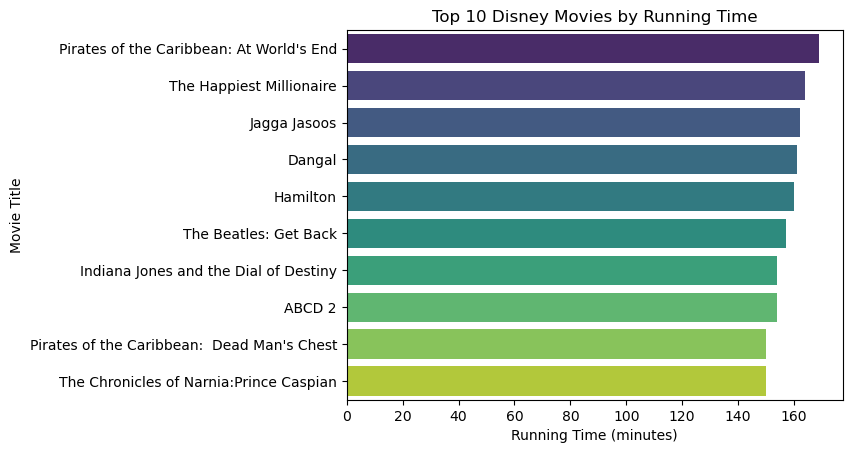

In [348]:
sns.barplot(data=top_10_longest_movies, x="Running time (minutes)", y="title", palette="viridis")
plt.title('Top 10 Disney Movies by Running Time')
plt.xlabel('Running Time (minutes)')
plt.ylabel('Movie Title');

### Top 10 movies with highest Box office

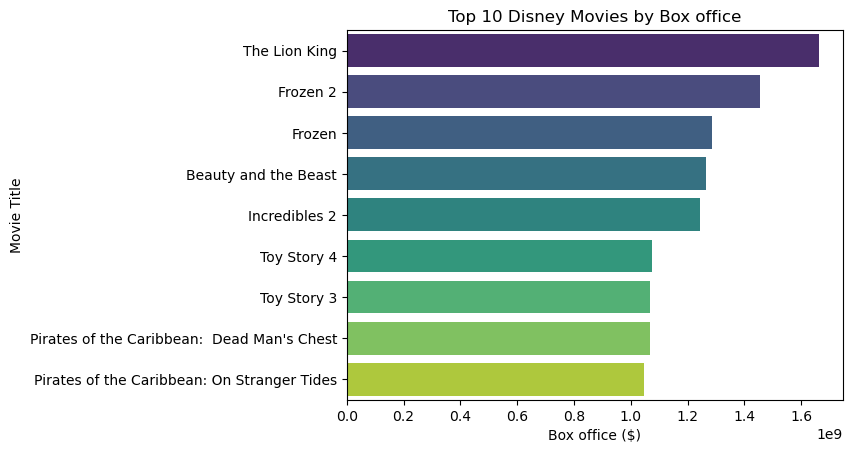

In [349]:
sns.barplot(data=top_10_highest_Box_office, x="Box office ($)", y="title", palette="viridis")
plt.title('Top 10 Disney Movies by Box office')
plt.xlabel('Box office ($)')
plt.ylabel('Movie Title');

### Movies in which "Chris Buck" was director

In [366]:
df[df["Directed by"].apply(lambda x: "Chris Buck" in x if isinstance(x, list) else False)]

,title,Directed by,Produced by,Starring,Music by,Distributed by,Country,Language,Running time (minutes),Box office ($),...,Cinematography,Edited by,Production companies,Genre,Plot,Awards,Poster,imdb,metascore,rotten_tomatoes (%)
Tarzan,Tarzan,"[Kevin Lima, Chris Buck]",[Bonnie Arnold],"[Tony Goldwyn, Minnie Driver, Glenn Close, Ale...",[Mark Mancina],[Buena Vista Pictures Distribution],United States,English,88.0,4.482000e+08,...,NaN,[Gregory Perler],"[Walt Disney Pictures, Walt Disney Feature Ani...","[Animation, Adventure, Comedy]",A man raised by gorillas must decide where he ...,Won 1 Oscar. 11 wins & 23 nominations total,https://m.media-amazon.com/images/M/MV5BY2ZiYW...,7.3,79.0,89.0
Frozen,Frozen,"[Chris Buck, Jennifer Lee]",[Peter Del Vecho],"[Kristen Bell, Idina Menzel, Jonathan Groff, J...","[Christophe Beck (score), Robert Lopez (songs)...","[Walt Disney Studios, Motion Pictures]",United States,English,102.0,1.285000e+09,...,[Mohit Kallianpur],[Jeff Draheim],"[Walt Disney Pictures, Walt Disney Animation S...","[Animation, Adventure, Comedy]",When the newly crowned Queen Elsa accidentally...,Won 2 Oscars. 83 wins & 60 nominations total,https://m.media-amazon.com/images/M/MV5BMTQ1Mj...,7.4,75.0,90.0
Frozen II,Frozen 2,"[Chris Buck, Jennifer Lee]",[Peter Del Vecho],"[Kristen Bell, Idina Menzel, Josh Gad, Jonatha...","[Christophe Beck (score), Robert Lopez (songs)...","[Walt Disney Studios, Motion Pictures]",United States,English,103.0,1.453000e+09,...,[Mohit Kallianpur],[Jeff Draheim],"[Walt Disney Pictures, Walt Disney Animation S...","[Documentary, Family]",With less than a year until the world premiere...,N/A,https://m.media-amazon.com/images/M/MV5BYmQ5ZW...,8.5,NaN,NaN
Wish,Wish,"[Chris Buck, Fawn Veerasunthorn]","[Peter Del Vecho, Juan Pablo Reyes]","[Ariana DeBose, Chris Pine, Alan Tudyk]",[David Metzger],"[Walt Disney Studios, Motion Pictures]",United States,English,NaN,NaN,...,NaN,NaN,"[Walt Disney Pictures, Walt Disney Animation S...","[Animation, Adventure, Comedy]",When Puss in Boots discovers that his passion ...,Nominated for 1 Oscar. 5 wins & 51 nominations...,https://m.media-amazon.com/images/M/MV5BNjMyMD...,7.9,73.0,NaN
